# ADMIXTURE

## General Settings

In [1]:
% matplotlib inline
% load_ext autoreload
% autoreload 2

% run general_settings.py
# ^ Takes ~20s to run if it finds the dumpfiles
# ^ WARNING: It will hog ~2.02 Gb RAM

[21:14:32] 'panels' dict
[21:14:32] 'galanter', 'present', 'missing' dataframes
[21:14:32] 'panel_labels'
[21:14:32] 'panel_names' dict
[21:14:32] 'panel_rsIDs' dict
[21:14:32] 'genome' dataframe
[21:14:37] 'lat' dataframe
[21:14:51] 'control_genotypes' huge datagrame
[21:14:51] 'control_rsIDs' dict to filter it ^
[21:14:51] 'cp_factors' list
[21:14:51] 'control_names' dict
[21:14:51] 'df_1000G_samples'
[21:14:51] 'df_1000G_SNPs'
[21:14:51] 'df_1000G_genotypes'
[21:14:51] 'df_1000G_populations'
[21:14:51] 'df_1000G_genotypes_alleles'

/home/juan/repos/tesina/settings/genome.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  centromers["chromosome"] = [i.replace("CEN", "") for i in centromers.index]
/home/juan/anaconda3/lib/python3.5/site-packages/pandas/io/parsers.py:1572: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())



[21:14:51] 'mafs' dataframe


/home/juan/anaconda3/lib/python3.5/site-packages/pandas/io/parsers.py:1574: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


In [ ]:
# panels_indices = {
#     "galT": galanter.index,
#     "galP": present.index,
#     "controlx1": control_genotypes.columns,
#     "controlx10": control_2_genotypes.columns,
#     "controlx100": control_3_genotypes.columns,
# }

# for panel_tag, panel_indices in panels_.items():
#     df_1000G_SNPs.index.intersection(panel_indices).values.tofile(
#         "~/tesina/admixture/{}.snps".format(panel_tag), sep="\n", format="%s"
#     )

## Plot CV Errors

In [10]:
%%bash

# Generar el `CV_error_summary` que leo para los gráficos siguientes:

location=`pwd`
cd /home/juan/tesina/admixture
grep CV */*.log > CV_error_summary
cat CV_error_summary | sed s'#[/:)]#,#g' | sed s'/CV error (K=//g' | awk -F, '{OFS=","; print $1, $3, $5}' | sed s'/, /,/g' > CV_error_summary.clean
cd $location

KeyError: 'galP'

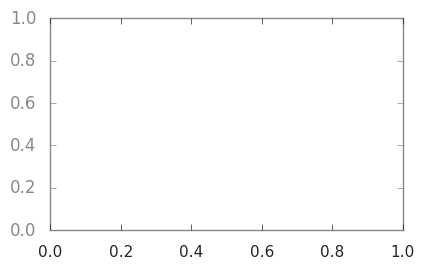

In [13]:
from itertools import product
from helpers.plot_helpers import population_colors

cv_errors = pd.read_csv("~/tesina/admixture/CV_error_summary.clean",
                        names=['dataset_panel', 'K', 'CV_error'])

cv_errors['dataset'] = cv_errors['dataset_panel'].apply(lambda x: x.split("_")[0])
cv_errors['panel'] = cv_errors['dataset_panel'].apply(lambda x: x.split("_")[1])
cv_errors = cv_errors.drop('dataset_panel', axis=1)
cv_errors = cv_errors.set_index(['dataset', 'panel', 'K']).sort_index()


Ks = cv_errors.index.get_level_values('K').unique()

width, height = (5, 3)
cols, rows = (2, 3)
fig = plt.figure(figsize=(width * cols, height * rows))
axes = list(np.arange(cols * rows) + 1)
axes.reverse()

datasets = cv_errors.index.get_level_values('dataset').unique()
for dataset in datasets:
    
    ax = plt.subplot(rows, cols, axes.pop())
    lines = []
    
    panels = cv_errors.loc[dataset].index.get_level_values('panel').unique()
    panels = [panel for panel in panels if "gal" in panel]  # Filter out the control panels for this chart
    for panel in panels:
        data = cv_errors.loc[(dataset, panel)]            
        data.plot(ax=ax, marker=".", color=population_colors(panel), zorder=1)
        
        x_min = data['CV_error'].idxmin()
        y_min = data['CV_error'].min()
        min_marker = ax.scatter(x_min, y_min, marker="v", color="DarkGreen", zorder=2, s=35)
        
        # TODO: Add a special mark at the minimum y value
    
    lines, labels = ax.get_legend_handles_labels()
    panel_labels = [panel_names[panel] for panel in panels]
    ax.set_title("Dataset: " + dataset_names[dataset], fontsize=12)
    ax.set_ylabel("CV Error", fontsize=11)
    ax.set_xlabel("K", fontsize=11)
    ax.legend_.remove()

# Ugly hack to get the legend in a separate subplot slot
ax = plt.subplot(rows, cols, axes.pop())
ax.legend(lines + [min_marker], panel_labels + ['Valor óptimo de K'],
          fontsize=13, loc='upper left', fancybox=True, scatterpoints=1)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
for loc in ['top', 'bottom', 'left', 'right']:
    ax.spines[loc].set_visible(False)

plt.tight_layout()
plt.show()

## Plot ADMIXTURE ancestry ratios per individual

In [ ]:
from collections import OrderedDict
from collections import defaultdict


dataset_Ks = OrderedDict([("L", 3), ("LE", 3), ("LEA", 3), ("LEAC", 4), ("LEACI", 5)])
panels = ["galT", "galP", "controlx1", "controlx10", "controlx100"]
admixture_results = defaultdict(OrderedDict)
ancestral_components = {0: 'EUR', 1: 'NAM', 2: 'AFR', 3: 'EAS', 4: 'SAS'}

population_groups = OrderedDict([
    ('Latinos',   ['CLM', 'MXL', 'PEL', 'PUR']),
    ('Europeos',  ['TSI', 'IBS']),
    ('Africanos', ['LWK', 'YRI']),
    ('Chinos',    ['CHS', 'CHB']),
    ('Indios',    ['GIH'])
])

In [ ]:
for dataset_tag, optimal_K in dataset_Ks.items():
    for panel_tag in panels:
        fdir = "~/tesina/admixture/{}_{}/".format(dataset_tag, panel_tag)
        filename = "{}_{}.{}.Q".format(dataset_tag, panel_tag, optimal_K)
        samples_filename = "{}_{}.fam".format(dataset_tag, panel_tag)
        ancestry_values = pd.read_csv(fdir + filename, sep="\s+",
                                      names=list(range(optimal_K)))
        sample_ids = pd.read_csv(fdir + samples_filename, sep="\s+",
                                 index_col=0, usecols=[0], names=['sample_id'])
        ancestry_values['sample_id'] = sample_ids.index
        populations = df_1000G_sample_populations.loc[sample_ids.index]['population']
        ancestry_values['population'] = populations.values
        ancestry_values['super_population'] = [df_1000G_population_names.loc[population]['Super Population Code']
                                               for population in populations.values]

        # Reorder ancestry columns to always have the same ancestral populations
        # in the same positions (and then the same order and colors in the plots).
        # Desired order: European, Amerindian, African, Chinese, Indian
        # This is necessarily hardcoded after visual inspection of the plots.
        fixed_columns = ['sample_id', 'population', 'super_population']
        if panel_tag == "galT":
            if dataset_tag == "L":
                ancestry_values = ancestry_values[[2, 0, 1] + fixed_columns]
            if dataset_tag == "LE":
                ancestry_values = ancestry_values[[2, 0, 1] + fixed_columns]
            if dataset_tag == "LEA":
                ancestry_values = ancestry_values[[2, 1, 0] + fixed_columns]
            if dataset_tag == "LEAC":
                ancestry_values = ancestry_values[[1, 3, 2, 0] + fixed_columns]
            if dataset_tag == "LEACI":
                ancestry_values = ancestry_values[[3, 0, 2, 1, 4] + fixed_columns]
        if panel_tag == "galP":
            if dataset_tag == "L":
                ancestry_values = ancestry_values[[2, 0, 1] + fixed_columns]
            if dataset_tag == "LE":
                ancestry_values = ancestry_values[[2, 1, 0] + fixed_columns]
            if dataset_tag == "LEA":
                ancestry_values = ancestry_values[[1, 2, 0] + fixed_columns]
            if dataset_tag == "LEAC":
                ancestry_values = ancestry_values[[3, 1, 0, 2] + fixed_columns]
            if dataset_tag == "LEACI":
                ancestry_values = ancestry_values[[3, 0, 2, 1, 4] + fixed_columns]
        if panel_tag == "controlx1":
            if dataset_tag == "L":
                ancestry_values = ancestry_values[[1, 2, 0] + fixed_columns]
            if dataset_tag == "LE":
                ancestry_values = ancestry_values[[1, 0, 2] + fixed_columns]
            if dataset_tag == "LEA":
                ancestry_values = ancestry_values[[1, 2, 0] + fixed_columns]
            if dataset_tag == "LEAC":
                ancestry_values = ancestry_values[[3, 0, 2, 1] + fixed_columns]
            if dataset_tag == "LEACI":
                ancestry_values = ancestry_values[[4, 0, 2, 3, 1] + fixed_columns]
        if panel_tag == "controlx10":
            if dataset_tag == "L":
                ancestry_values = ancestry_values[[2, 0, 1] + fixed_columns]
            if dataset_tag == "LE":
                ancestry_values = ancestry_values[[2, 0, 1] + fixed_columns]
            if dataset_tag == "LEA":
                ancestry_values = ancestry_values[[2, 1, 0] + fixed_columns]
            if dataset_tag == "LEAC":
                ancestry_values = ancestry_values[[3, 0, 2, 1] + fixed_columns]
            if dataset_tag == "LEACI":
                ancestry_values = ancestry_values[[4, 0, 2, 3, 1] + fixed_columns]
        if panel_tag == "controlx100":
            if dataset_tag == "L":
                ancestry_values = ancestry_values[[2, 0, 1] + fixed_columns]
            if dataset_tag == "LE":
                ancestry_values = ancestry_values[[1, 0, 2] + fixed_columns]
            if dataset_tag == "LEA":
                ancestry_values = ancestry_values[[2, 1, 0] + fixed_columns]
            if dataset_tag == "LEAC":
                ancestry_values = ancestry_values[[3, 0, 2, 1] + fixed_columns]
            if dataset_tag == "LEACI":
                ancestry_values = ancestry_values[[4, 0, 2, 3, 1] + fixed_columns]
                
        # Reassign the column numbers
        columns_renumbered = list(range(len(ancestry_values.columns) - len(fixed_columns)))
        ancestry_values.columns = (columns_renumbered + fixed_columns)
        
        # Replace the numbers with the continental population codes
        # This naming of the ancestry columns only makes sense with the previous ordering,
        # which placed the components in the same order as the one in "ancestral_components"
        renamed_columns = [ancestral_components[n] for n in ancestry_values.columns
                          if n not in fixed_columns]
        ancestry_values.columns = renamed_columns + fixed_columns
        
        # Reorder the named columns
        ancestral_components_ordered = list(ancestral_components.values())[:len(renamed_columns)]
        ancestry_values = ancestry_values[ancestral_components_ordered + fixed_columns]

        # Sort the samples
        ancestry_values = ancestry_values.sort_values(['super_population', 'population', 'EUR'])
        ancestry_values = ancestry_values.reset_index(drop=True)

        admixture_results[dataset_tag][panel_tag] = ancestry_values

In [ ]:
from collections import OrderedDict


def config_admixture_plot(ax, df, ylabel_on=True):
    ax.set_title(panel_name, fontsize=14, position=(0.5, 1.4))
    
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    
    # Set population names on the xticks
    indices_by_population = [df[df['population'] == population].index.values
                             for population in df['population'].unique()]
    xtick_positions = [np.median(indices) for indices in indices_by_population]
    ax.set_xticks(xtick_positions)
    ax.set_xticklabels(df['population'].unique(), rotation=0)
    ax.xaxis.set_ticks_position("top")

    # Separate the populations with a line
    
    separation_lines = [max(indices) for indices in indices_by_population]
    [plt.axvline(x=x, color="k", lw=1) for x in separation_lines[:-1]]

    if ylabel_on:
        ax.set_ylabel("Proporción de\nancestrías", fontsize=11)
        
    ax.set_ylim((0, 1))
    ax.set_yticks([])
    ax.set_frame_on(False)
    ax.legend().set_visible(False)

    return ax

for dataset_tag, panel_results in admixture_results.items():
    K = dataset_Ks[dataset_tag]
    dataset_name = dataset_names[dataset_tag].replace("\n", " ")
        
    # One figure per panel per dataset on top
    
    rows = len(panels)
    fig = plt.figure(figsize=(12, 2 * rows))
    axes = (np.arange(len(panels)) + 1).tolist()[::-1]
    
    for panel_tag, df in panel_results.items():
        panel_name = panel_names[panel_tag]
        ax = plt.subplot(rows, 1, axes.pop())
        df.plot(ax=ax, kind="bar", stacked=True, width=1, linewidth=0)
        ax = config_admixture_plot(ax, df)
    
    plt.tight_layout()
    
    title = "Dataset: {} ($K={}$)".format(dataset_name, K)
    fig.suptitle(title, fontsize=17)
    plt.subplots_adjust(top=(0.75))  # Make space for the fig.suptitle
    
    plt.show()
    
#     # Detail plots for each population group
    
#     # Detail plots dimensions and subplot number generation
#     width, height = (6, 2)
    
#     # Hacky! Dataset tags are acronyms of the population groups
#     # So I'm inferring the number of population group from the length of the tag.
#     cols, rows = (2, len(dataset_tag))  # One row of plots per population group
    
#     if dataset_tag == "L":
#         rows = len(population_groups["Latinos"])
    
#     fig = plt.figure(figsize=(width * cols, height * rows))

#     odd_subplots = [n for n in np.arange(rows * cols) + 1 if n % 2 != 0]
#     even_subplots = list(np.array(odd_subplots) + 1)
#     axes = {"galT": odd_subplots[::-1], "galP": even_subplots[::-1]}

#     sorted_index = []  # Hack. See (1) below.

#     # One subplot per population group per panel in the dataset
#     for panel_tag, df in panel_results.items():
#         panel_name = panel_names[panel_tag]
        
#         if dataset_tag == "L":
#             # Hack to get one plot per latino population in this dataset
#             pg = dict([(p, [p]) for p in population_groups["Latinos"]])
#         else:
#             pg = population_groups
            
#         for population_group_name, population_group in pg.items():
#             mask = df['population'].isin(population_group)
#             df_pop = df[mask].dropna()
#             if len(df_pop) == 0:
#                 continue
    
#             # (1) Hack to get the same sample order in both columns of plots
#             if panel_tag == "galT":
#                 sorted_index = [df_pop.index] + sorted_index
#             elif panel_tag == "galP":
#                 df_pop = df_pop.loc[sorted_index.pop()]

#             # I need consecutive indices for the xtick labels position calculation later:
#             df_pop = df_pop.reset_index(drop=True)
            
#             ax_id = axes[panel_tag].pop()
#             ax = plt.subplot(rows, cols, ax_id)
#             df_pop.plot(ax=ax, kind="bar", stacked=True, width=1, linewidth=0)
            
#             ylabel_on = (ax_id % 2 != 0)  # Y-axis label only on plots on the left (odd plots)
#             title_on = (ax_id in [1, 2])  # Only top plots carry the panel_name as title

#             ax = config_admixture_plot(ax, df_pop, ylabel_on=ylabel_on)

#     plt.tight_layout()
#     plt.show()

In [ ]:
def get_superpop_from_poptag(tag):
    ref = df_1000G_population_names

    if tag not in ref.index:
        return tag
    
    return ref.loc[tag]['Super Population Code']

def config_admixture_mean_plot(ax, df, title=None, ylabel_on=True):
    if title:
        ax.set_title(title, fontsize=12.5, fontweight="bold")

#     if ylabel_on:
#         ax.set_ylabel("Proporción de\nancestrías", fontsize=11)

    ax.set_ylim((-0.05, 1.05))
    ax.set_yticks([])
    
    xticklabels = plt.xticks()[1]
    xticks_rot = 0 if len(xticklabels) < 10 else 45
    ax.set_xticklabels(xticklabels, rotation=xticks_rot)
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xlabel("")
    ax.set_frame_on(False)
    ax.legend_.remove()

    return ax


for dataset_tag, panel_results in admixture_results.items():
    K = dataset_Ks[dataset_tag]
    dataset_name = dataset_names[dataset_tag].replace("\n", " ")
    
    rows, cols = len(panel_results.keys()), 1
    fig = plt.figure(figsize=(cols * width, rows * height))
    axes = (np.arange(rows * cols) + 1).tolist()[::-1]
    
    for panel_tag, df in panel_results.items():
        
        panel_name = panel_names[panel_tag]
        ax_id = axes.pop()
        ax = plt.subplot(rows, cols, ax_id)
        
        by_population = df.groupby("population").mean()
        # by_superpopulation = df.groupby("super_population").mean()
        # both = pd.concat([by_population, by_superpopulation])

        by_population["superpop"] = [get_superpop_from_poptag(ix)
                                     for ix in by_population.index.values]
        by_population = by_population.sort_values(["superpop", "EUR"])
        
        by_population.plot(ax=ax, kind="bar", stacked=True, width=1, lw=0.35, rot=0)
        config_admixture_mean_plot(ax, by_population, title=panel_name, ylabel_on=True)
    
    figtitle = "{} (K={})".format(dataset_name, K)
    fig.suptitle(figtitle, fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.subplots_adjust(top=(0.90))
    plt.show()